AiApp Miniproject; Leonie Däullary, Ruwen Frick

Imports

Prerequisites

Pyhton with pip installed.

In [20]:
pip install opendatasets tensorflow matplotlib

Note: you may need to restart the kernel to use updated packages.


In [21]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import opendatasets as od
import pathlib as pathl
import os

Dowloading the data

1. Sign in to https://kaggle.com/ or register a new account, then click on your profile picture on the top right and select "My Account" from the menu.

2. Scroll down to the "API" section and click "Create New API Token". This will download a file kaggle.json with the following contents:
    {"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}

In [23]:
dataset_url = "https://www.kaggle.com/pranavraikokte/covid19-image-dataset"
od.download(dataset_url)

path = pathl.Path(".", "covid19-image-dataset", "Covid19-dataset").absolute()
print(f"Data stored at: {path}")

train_path = pathl.Path(path, "train")
test_path = pathl.Path(path, "test")

class_names = ['Covid', 'Normal', 'Viral Pneumonia']

# https://www.kaggle.com/code/ezzaldin6/covid-19-detection-100-accuracy


Skipping, found downloaded files in ".\covid19-image-dataset" (use force=True to force download)
Data stored at: c:\Users\ruwen\OneDrive\Dokumente\HSR\_Coding Projekte\_VSCode\covid-detection\code\covid19-image-dataset\Covid19-dataset


Print out some examples

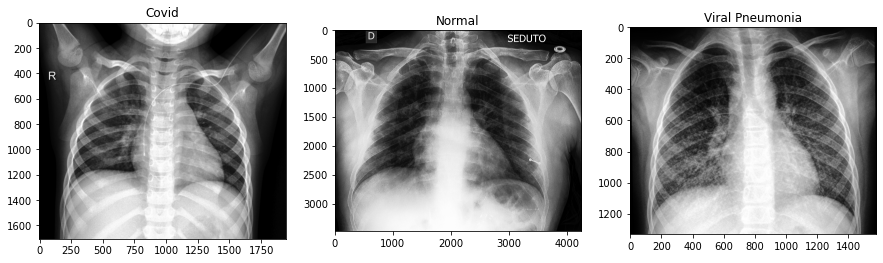

In [17]:
normal_path = pathl.Path(train_path, "Normal", "01.jpeg")
covid_path = pathl.Path(train_path, "Covid", "01.jpeg")
pneumonia_path = pathl.Path(train_path, "Viral Pneumonia", "01.jpeg")

plt.figure(figsize = (15, 15))
covid_img = mpimg.imread(normal_path)
normal_img = mpimg.imread(covid_path)
pneonomia_img = mpimg.imread(pneumonia_path)
plt.subplot(1, 3, 1)
plt.imshow(covid_img)
plt.title('Covid')
plt.subplot(1, 3, 2)
plt.imshow(normal_img)
plt.title('Normal')
plt.subplot(1, 3, 3)
plt.imshow(pneonomia_img)
plt.title('Viral Pneumonia')
plt.show()

Preprocessing and Data Augmentation

In [31]:
# Data generation parameters
rescale = 1. / 255
target_size = (255, 255)
horizontal_flip = True
zoom_range = [0, 0.1]
rotation_range = 25
shear_range = 0.2
batch_size  = 64
validation_split = 0.125

train_valid_data_generator = ImageDataGenerator(
    rescale = rescale,
    horizontal_flip = horizontal_flip,
    zoom_range = zoom_range,
    rotation_range = rotation_range,
    shear_range = shear_range,
    validation_split = validation_split
)

test_data_generator = ImageDataGenerator(
    rescale = rescale
)

train_data = train_valid_data_generator.flow_from_directory(
    train_path,
    target_size = target_size,
    batch_size  = batch_size,
    subset = 'training'
)
valid_data = train_valid_data_generator.flow_from_directory(
    train_path,
    target_size = target_size,
    batch_size  = batch_size,
    subset = 'validation'
)

test_data = test_data_generator.flow_from_directory(
    test_path,
    target_size = target_size,
    batch_size  = batch_size,
)


Found 222 images belonging to 3 classes.
Found 29 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [ ]:
model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))